# Analysis of covid-19 cases in the Netherlands

In [1]:
#Import the useful stuff
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
from datetime import datetime,date


In [2]:
#The dataframe has some errors, so it has to be imported this way
df = pd.read_csv('https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_cumulatief.csv', header=None, sep='\n')

In [3]:
#Let's format the dataframe correctly
df = df[0].str.split(';', expand=True)
#Set the correct column names
df.columns = df.iloc[0]
df.drop([0],inplace=True)
#Set the correct index and remove index name
df.set_index('Date_of_report',inplace=True)
df.index.name = None
#Convert the date inside the dataframe to the correct data types
l = []
for date in df.index:
    l.append(date.split(' ')[0])
df.index = l
for val in ['Total_reported','Hospital_admission','Deceased']:
    df[val] = df[val].astype('int')
#Remove hour value from the index since it is irrelevant

#Add column for new daily cases
index_length = len(df.index)
days = len(df.index.unique())
df = df.assign(New_cases=pd.Series(np.zeros(index_length,dtype=int)).values)

In [4]:
#There does not seem to be an url to a csv with the population of each Gemeente. Let's use this csv from opendata.cbs.nl
population = pd.read_csv('gemeente_population.csv')
#Adjust the dataframe
population.set_index('Bevolkingsontwikkeling; regio per maand',inplace=True)
population.index.name = None
#Unfortunately for many Gemeentes there is no population data, so we have to drop those rows
#If necessary, data can be taken from here: https://nl.wikipedia.org/wiki/Tabel_van_Nederlandse_gemeenten
population.dropna(inplace=True)
population.drop(['Unnamed: 1','Unnamed: 2'],axis =1,inplace=True)
#Rename the column
population['Population'] = population['Unnamed: 3']
population.drop(['Unnamed: 3'],axis =1,inplace=True)
#Remove the "gemeente" word from some index values
for val in population.index:
    if '(gemeente)' in val:
        population.rename(index={val:val.split('(')[0][:-1]}, inplace = True)
#Convert the values to int
population['Population'] = population['Population'].astype('int')

In [5]:
#Create a new dataframe for the national data
df_netherlands = df.groupby(df.index).sum()
# Compute the new cases. The new cases for 13-03-20 are taken from:
#https://www.worldometers.info/coronavirus/country/netherlands/
df_netherlands['New_cases'].iloc[1:] = df_netherlands.Total_reported.iloc[1:].values - df_netherlands.Total_reported.iloc[0:-1].values
df_netherlands['New_cases'].iloc[0] = 190

In [6]:
for city in df.Municipality_name.unique():
    if city == '':
        continue
    new_cases = np.zeros(len(df.index.unique()),dtype = int)
    city_df = df.loc[df['Municipality_name'] == city]
    #Compute the number of new cases
    new_cases[1:] = city_df.iloc[1:len(city_df),:].loc[:,'Total_reported'].values - city_df.iloc[0:len(city_df)-1,:].loc[:,'Total_reported'].values
    df.loc[df['Municipality_name'] == city,'New_cases'] = new_cases.astype('int')

#Convert the column New_cases to int type
df.New_cases = df.New_cases.astype(int)



## Plots

### Useful functions

In [7]:
def plot_city(city,df,population,column,normalization=False,kind='line'):
    data = get_city(df,city)
                    
    if normalization:
        y = data[[column]]/population.loc[city][0]*100000
    else:
        y = data[[column]]
    
    if kind == 'line':
        plt.plot(y,label = city)
        
    elif kind == 'bar':
        y = y[column].values
        plt.bar(x = data.index, height = y,label = city)
    
    
        
def get_city(df,city):
    return df.loc[df['Municipality_name'] == city]

### National data plots

In [8]:
#Define the ticks for the logarithmic scale
max_cases = df_netherlands.Total_reported.max()
start = 3
finish = 8 #The Netherlands has less than 100 milion people but more than 10 milion
powers = np.logspace(start,finish,num=finish - start +1,base=10,dtype='int')
#Define the y-ticks
spacing = [1, 2, 5]
powers = np.logspace(3,5,num=3,base=10,dtype='int')
ticks = np.kron(spacing,powers)
ticks.sort()
ticks = ticks.tolist()
#Keep only one tick higher than the current maximum, remove the other ones
temp = [x for x in ticks if x <= max_cases]
ticks_y_log = ticks[:len(temp)+1]

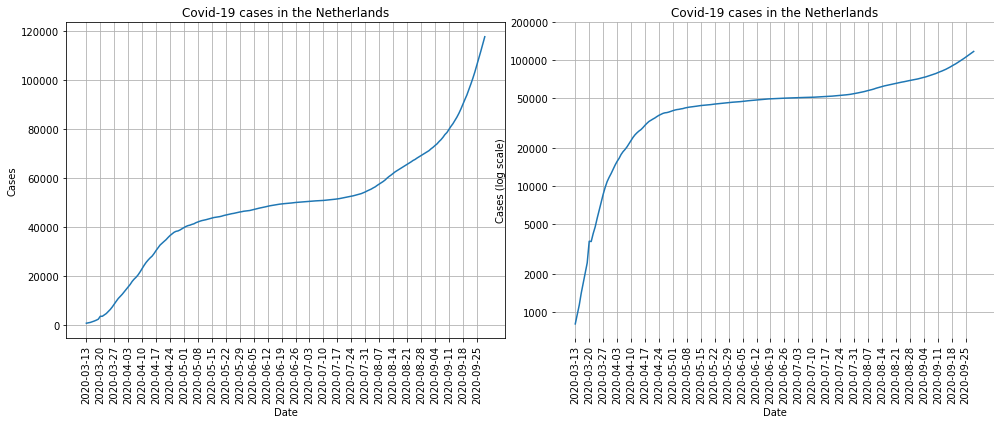

In [9]:
#Plot both a linear plot and a y-log one
plt.figure(figsize=(14,6))

ax1=plt.subplot(1, 2, 1)
plt.plot(df_netherlands.Total_reported)
plt.xticks(rotation=90)
plt.xticks(np.arange(0, days, 7))
plt.title('Covid-19 cases in the Netherlands')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.grid()
plt.tight_layout()

ax2=plt.subplot(1,2,2, frameon=False)
plt.plot(df_netherlands.Total_reported)
plt.yscale('log')
plt.xticks(rotation=90)
plt.xticks(np.arange(0, days, 7))
max_cases = df_netherlands.Total_reported.max()
min_cases = df_netherlands.Total_reported.min()
#plt.yticks(np.arange(max(min_cases,1000), max_cases,(max_cases-min_cases)/10))

plt.title('Covid-19 cases in the Netherlands')
plt.xlabel('Date')
plt.ylabel('Cases (log scale)')
plt.grid()
plt.tight_layout()
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax2.set_yticks(ticks_y_log)
#ax2.yaxis.set_major_locator(plt.MaxNLocator(nbins = 10, steps = [1, 2, 3,4, 5, 10],integer = True))
locs = np.append( np.arange(0.1,100,0.1),np.arange(1,100,0.2))
ax2.yaxis.set_minor_locator(ticker.FixedLocator(locs))

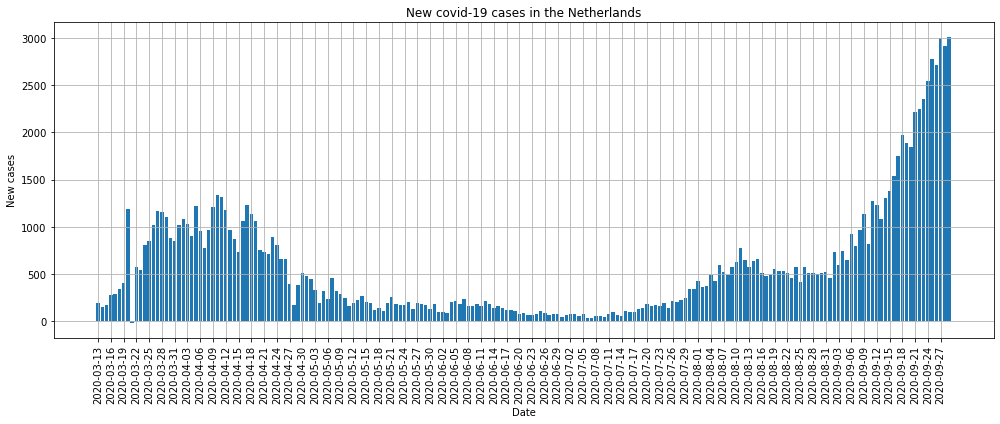

In [10]:
plt.figure(figsize=(14,6))

plt.bar(x = df_netherlands.index, height=df_netherlands.New_cases)

plt.xticks(rotation=90)
plt.xticks(np.arange(0, days,3))
plt.title('New covid-19 cases in the Netherlands')
plt.xlabel('Date')
plt.ylabel('New cases')
plt.grid()
plt.tight_layout()

### Plots per gemeente

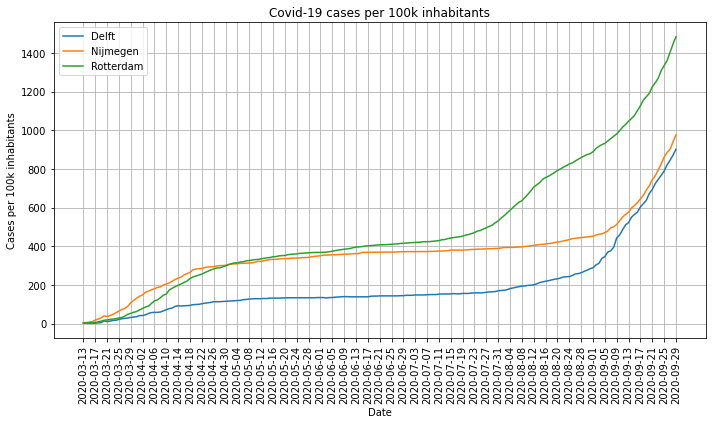

In [24]:
plt.figure(figsize=(10,6))

normalize = True
plot_city('Delft',df,population,'Total_reported',normalize)
plot_city('Nijmegen',df,population,'Total_reported',normalize)
plot_city('Rotterdam',df,population,'Total_reported',normalize)

plt.xticks(rotation=90)
plt.xticks(np.arange(0, days,4))
plt.legend()

plt.title('Covid-19 cases per 100k inhabitants' if normalize else 'Covid-19 cases')
plt.xlabel('Date')
plt.ylabel('Cases per 100k inhabitants' if normalize else 'Cases')
plt.grid()
plt.tight_layout()

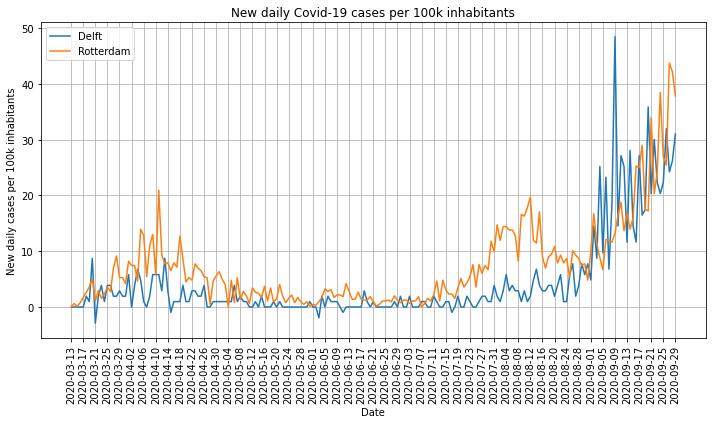

In [32]:
plt.figure(figsize=(10,6))

normalize = True
plot_city('Delft',df,population,'New_cases',normalize)
plot_city('Rotterdam',df,population,'New_cases',normalize)


plt.xticks(rotation=90)
plt.xticks(np.arange(0, days,4))
plt.legend()
plt.title('New daily Covid-19 cases per 100k inhabitants' if normalize else 'New daily Covid-19 cases')
plt.xlabel('Date')
plt.ylabel('New daily cases per 100k inhabitants' if normalize else 'New Daily Covid-19 cases')

plt.grid()
plt.tight_layout()

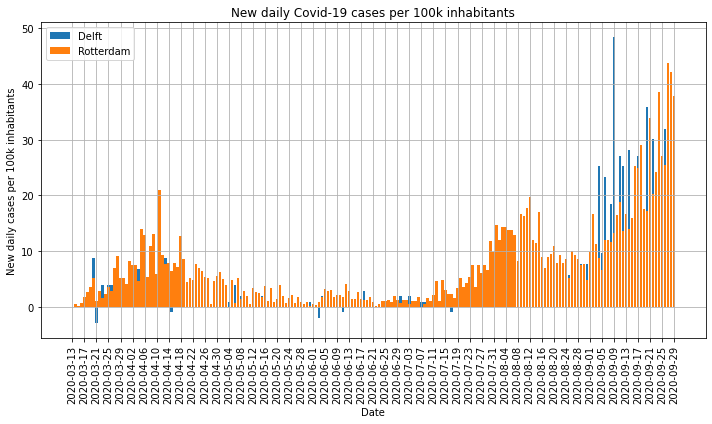

In [33]:
plt.figure(figsize=(10,6))

normalize = True
plot_city('Delft',df,population,'New_cases',normalize,'bar')
plot_city('Rotterdam',df,population,'New_cases',normalize,'bar')

plt.xticks(rotation=90)
plt.xticks(np.arange(0, days,4))
plt.legend()
plt.title('New daily Covid-19 cases per 100k inhabitants' if normalize else 'New daily Covid-19 cases')
plt.xlabel('Date')
plt.ylabel('New daily cases per 100k inhabitants' if normalize else 'New Daily Covid-19 cases')
plt.grid()
plt.tight_layout()